In [2]:
import os
os.chdir('..')
from notebooks import config
import geopandas as gpd
import glob
import h5py
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import MultiPolygon, box
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib import cm
from utils.geotif_io import readTiff,writeTiff
from utils.imgShow import imgShow
from utils.transform_xy import coor2coor, geo2imagexy
from utils.raster_vec import vec2mask
import numpy as np


In [3]:
path_tandem = config.root_proj + '/data/dem/TanDem90_StudyArea_resize_resam.tif'   # wgs84 height
path_img = config.root_proj + '/data/rsimg/l8_kunlun_20200914.tif'
path_glacier_vec = config.root_proj +'/data/rgi/rgi60_1305_StudyArea/rgi60_1305_subs.shp'


In [4]:
geodf_rgi1305 = gpd.read_file(path_glacier_vec)
rs_img, rs_img_info = readTiff(path_img)
img_dem, img_dem_info = readTiff(path_tandem)


In [56]:
## generate glacier mask
# rgi_mask_path = 'data/rgi/rgi60_1305_StudyArea/mask_based_dem.tif'
# mask = vec2mask(vec_path=path_glacier_vec, raster_path=path_dem, output_path=rgi_mask_path)
# rgi_mask, rgi_mask_info = readTiff(rgi_mask_path)
# plt.imshow(rgi_mask)


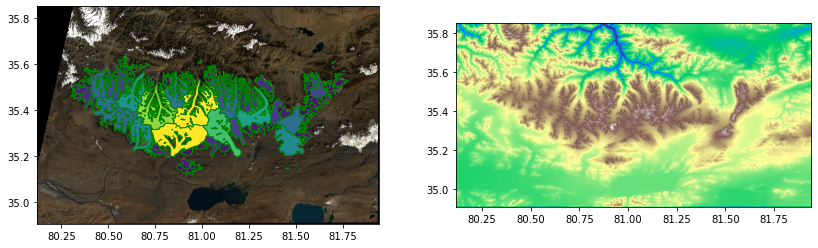

In [5]:
#### show remote sensing image, dem and rgi data
## show dem/rgi_data
plt.figure(figsize=(14, 4))
ax1 = plt.subplot(1,2,1)
imgShow(rs_img, extent = rs_img_info['geoextent'], \
                color_bands=(2, 1, 0), clip_percent=5)
geodf_rgi1305.plot('Area', ax=ax1, markersize=1, \
                              edgecolor='green', label='glacier')
ax2 = plt.subplot(1,2,2)
plt.imshow(img_dem, vmin=4000, vmax=7000, extent=img_dem_info['geoextent'], cmap='terrain')



<KeysViewHDF5 ['beam_type', 'cycle', 'h_elv', 'h_tandem', 'lat', 'lon', 'quality_summary', 'rgt', 'spot', 't_year']>


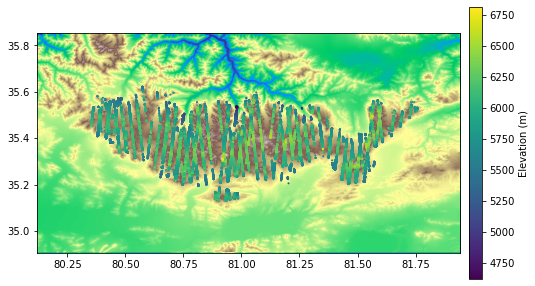

In [6]:
### atl06 data, one month
with h5py.File('data/icesat2/processed_atl06/atl06_2020_subs.h5','r') as f_a:
    lat_atl06   = f_a['lat'][:]
    lon_atl06   = f_a['lon'][:]
    h_elv_atl06 = f_a['h_elv'][:]
    quality_atl06 = f_a['quality_summary'][:]
    print(f_a.keys())
x_atl06, y_atl06 = coor2coor(srs_from=4326, \
                    srs_to=rs_img_info['geosrs'], x=lon_atl06, y=lat_atl06)

good = quality_atl06==0
plt.figure(figsize=(8,5))
plt.imshow(img_dem, vmin=4000, vmax=7000, extent=img_dem_info['geoextent'],cmap='terrain')
plt.scatter(x=x_atl06[good], y=y_atl06[good], c=h_elv_atl06[good], s=1)
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')



### *Append dem data into the h5 file*

In [7]:
!h5ls data/icesat2/processed_atl06/atl06_2020_subs.h5


beam_type                Dataset {171400}
cycle                    Dataset {171400}
h_elv                    Dataset {171400}
h_tandem                 Dataset {171400}
lat                      Dataset {171400}
lon                      Dataset {171400}
quality_summary          Dataset {171400}
rgt                      Dataset {171400}
spot                     Dataset {171400}
t_year                   Dataset {171400}


In [8]:
### append 
with h5py.File('data/icesat2/processed_atl06/atl06_2020_subs.h5','r') as f_a:
    lat_atl06_2020   = f_a['lat'][:]
    lon_atl06_2020   = f_a['lon'][:]
    quality_atl06_2020 = f_a['quality_summary'][:]

# good = quality_atl06_2020==0
row, col = geo2imagexy(x=lon_atl06_2020, \
                y=lat_atl06_2020, gdal_trans=img_dem_info['geotrans'])

## ensure the row, col fall in the image
row[row >= img_dem.shape[0]] = img_dem.shape[0]-1
col[col >= img_dem.shape[1]] = img_dem.shape[1]-1
h_dem = img_dem[row,col]

## append dem variable
with h5py.File('data/icesat2/processed_atl06/atl06_2020_subs.h5','a') as f_a:
  # del f_a['h_tandem']
  if 'h_tandem' not in f_a.keys():
    f_a.create_dataset("h_tandem", data=h_dem)


In [9]:
!h5ls data/icesat2/processed_atl06/atl06_2020_subs.h5

beam_type                Dataset {171400}
cycle                    Dataset {171400}
h_elv                    Dataset {171400}
h_tandem                 Dataset {171400}
lat                      Dataset {171400}
lon                      Dataset {171400}
quality_summary          Dataset {171400}
rgt                      Dataset {171400}
spot                     Dataset {171400}
t_year                   Dataset {171400}


In [10]:
## calculate difference 
with h5py.File('data/icesat2/processed_atl06/atl06_2020_subs.h5','r') as f_a:
    lat_atl06   = f_a['lat'][:]
    lon_atl06   = f_a['lon'][:]
    h_elv_atl06 = f_a['h_elv'][:]
    h_dem_atl06 = f_a['h_tandem'][:]
    h_time = f_a['t_year'][:]
    quality_atl06 = f_a['quality_summary'][:]

good = quality_atl06 == 0 
h_dif = h_elv_atl06 - h_dem_atl06


In [287]:
# plt.figure(figsize=(8,5))
# plt.imshow(img_dem, extent=img_dem_info['geoextent'],cmap='terrain')
# plt.scatter(x=x_atl06[good], y=y_atl06[good], c=h_dif[good], s=1, vmin=-40, vmax=40)
# plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')



### *linear fitting*

In [11]:

coeff = np.polyfit(h_time[good], h_dif[good], 1)
f = np.poly1d(coeff)
print('Intercept: %.3f' % coeff[0])
print('Slope: %.3f' % coeff[1])


Intercept: 0.001
Slope: 1.058


### *ransac fitting*

In [191]:
# import numpy as np
# from sklearn import linear_model
# x = h_time[good].reshape(-1, 1)
# y = h_dif[good].reshape(-1, 1)
# ransac = linear_model.RANSACRegressor(random_state=12)
# ransac.fit(x, y)
# y_ransac = ransac.predict(x)
# print('Slope: %.3f' % ransac.estimator_.coef_[0])
# print('Intercept: %.3f' % ransac.estimator_.intercept_)


Slope: -0.115
Intercept: 235.926


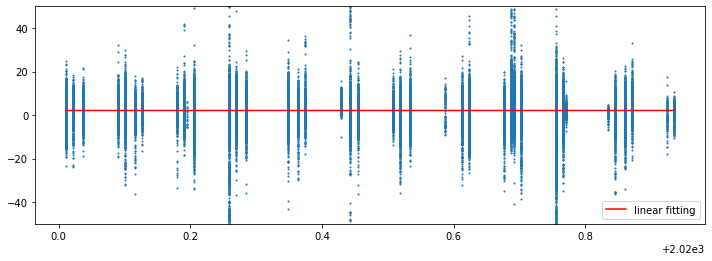

In [13]:
### !!! before wgs84 to egm2008
plt.figure(figsize=(12,4))
plt.scatter(h_time[good], h_dif[good], s=1)
plt.plot(h_time[good], f(h_time[good]), 'r-',label="linear fitting")
# plt.plot(x, y_ransac, color="green", label="RANSAC regressor")
plt.ylim(-50, 50)
plt.legend(loc="lower right")
